In [1]:
# Import the requests library.
import requests
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
import numpy as np

In [2]:
# Create variables for each of the data files
nyt_data = 'https://group3data.s3.us-west-2.amazonaws.com/us-counties.csv'
hospital_data = 'https://group3data.s3.us-west-2.amazonaws.com/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility.csv'
vaccination_data = 'https://group3data.s3.us-west-2.amazonaws.com/COVID-19_Vaccinations_in_the_United_States_County.csv'

In [3]:
# read in data from S3 bucket and create dataframes
nyt_data_df = pd.read_csv(nyt_data)
hospital_data_df = pd.read_csv(hospital_data)
vaccination_data_df = pd.read_csv(vaccination_data)

# Data Cleaning:
## NYT Data

In [4]:
# Find the data types for the NYT data
nyt_data_df.dtypes

date       object
county     object
state      object
fips      float64
cases       int64
deaths    float64
dtype: object

In [5]:
# Convert the date column in the NYT data to a datetime object using pd.to_datetime
nyt_data_df['date'] = pd.to_datetime(nyt_data_df['date'])
nyt_data_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [6]:
# 1. Remove the data for dates before 7-31-20 and after 10-22-21
# 2. Bin the date column by weeks ending every friday
# 3. Sum the cases and deaths columns for each week binned

# Step 1:
nyt_data_filtered = nyt_data_df[nyt_data_df['date'] >= '2020-07-25']
nyt_data_filtered = nyt_data_filtered[nyt_data_filtered['date'] <= '2021-10-22']
nyt_data_filtered

,date,county,state,fips,cases,deaths
366652,2020-07-25,Autauga,Alabama,1001.0,932,21.0
366653,2020-07-25,Baldwin,Alabama,1003.0,2662,18.0
366654,2020-07-25,Barbour,Alabama,1005.0,552,4.0
366655,2020-07-25,Bibb,Alabama,1007.0,318,2.0
366656,2020-07-25,Blount,Alabama,1009.0,637,1.0
...,...,...,...,...,...,...
1842600,2021-10-22,Sweetwater,Wyoming,56037.0,7414,79.0
1842601,2021-10-22,Teton,Wyoming,56039.0,5119,14.0
1842602,2021-10-22,Uinta,Wyoming,56041.0,3781,26.0
1842603,2021-10-22,Washakie,Wyoming,56043.0,1676,33.0


In [7]:
# Step 2:
# Step 3:
columns_to_sum = [nyt_data_filtered['cases'], nyt_data_filtered['deaths']]
nyt_data_grouped = nyt_data_filtered.groupby(['fips', pd.Grouper(key='date', freq='W-FRI')]).agg({'cases':'sum','deaths':'sum'}).reset_index()
nyt_data_grouped

,fips,date,cases,deaths
0,1001.0,2020-07-31,6817,147.0
1,1001.0,2020-08-07,7503,150.0
2,1001.0,2020-08-14,8531,158.0
3,1001.0,2020-08-21,9009,161.0
4,1001.0,2020-08-28,9484,161.0
...,...,...,...,...
208977,78030.0,2021-09-24,24720,297.0
208978,78030.0,2021-10-01,24982,304.0
208979,78030.0,2021-10-08,25204,308.0
208980,78030.0,2021-10-15,25290,311.0


In [8]:
# Resort the nyt_data_grouped by date
nyt_data_grouped = nyt_data_grouped.sort_values(by='date')
nyt_data_grouped

,fips,date,cases,deaths
0,1001.0,2020-07-31,6817,147.0
167222,48119.0,2020-07-31,88,0.0
32676,13241.0,2020-07-31,1161,21.0
167287,48121.0,2020-07-31,44680,448.0
32611,13239.0,2020-07-31,185,7.0
...,...,...,...,...
179867,48507.0,2021-10-22,17555,371.0
51697,19017.0,2021-10-22,24875,472.0
142867,40151.0,2021-10-22,11280,163.0
51177,19001.0,2021-10-22,7311,241.0


In [9]:
# Set each column to a string value so we can concatonate them together 
nyt_data_grouped['fips'] = nyt_data_grouped['fips'].astype('str')
nyt_data_grouped['date'] = nyt_data_grouped['date'].astype('str')
nyt_data_grouped['fips'].dtype

dtype('O')

In [10]:
# Concatonate the date column and the fips column to create fips_date
nyt_data_grouped['fips_date'] = nyt_data_grouped['fips'] + nyt_data_grouped['date']
nyt_data_grouped

,fips,date,cases,deaths,fips_date
0,1001.0,2020-07-31,6817,147.0,1001.02020-07-31
167222,48119.0,2020-07-31,88,0.0,48119.02020-07-31
32676,13241.0,2020-07-31,1161,21.0,13241.02020-07-31
167287,48121.0,2020-07-31,44680,448.0,48121.02020-07-31
32611,13239.0,2020-07-31,185,7.0,13239.02020-07-31
...,...,...,...,...,...
179867,48507.0,2021-10-22,17555,371.0,48507.02021-10-22
51697,19017.0,2021-10-22,24875,472.0,19017.02021-10-22
142867,40151.0,2021-10-22,11280,163.0,40151.02021-10-22
51177,19001.0,2021-10-22,7311,241.0,19001.02021-10-22


In [11]:
# Get the difference in the number of cases/deaths instead of the cumulative total
test_nyt = nyt_data_grouped[nyt_data_grouped['fips'] == '1001.0'].sort_values(by='date')
#nyt_data_grouped['cases'] = nyt_data_grouped['cases'].diff()

test_nyt['cases'] = test_nyt['cases'].diff()
test_nyt['deaths'] = test_nyt['deaths'].diff()
test_nyt

,fips,date,cases,deaths,fips_date
0,1001.0,2020-07-31,NaN,NaN,1001.02020-07-31
1,1001.0,2020-08-07,686.0,3.0,1001.02020-08-07
2,1001.0,2020-08-14,1028.0,8.0,1001.02020-08-14
3,1001.0,2020-08-21,478.0,3.0,1001.02020-08-21
4,1001.0,2020-08-28,475.0,0.0,1001.02020-08-28
...,...,...,...,...,...
60,1001.0,2021-09-24,1471.0,78.0,1001.02021-09-24
61,1001.0,2021-10-01,1035.0,55.0,1001.02021-10-01
62,1001.0,2021-10-08,688.0,27.0,1001.02021-10-08
63,1001.0,2021-10-15,403.0,14.0,1001.02021-10-15


In [12]:
# test diff() on whole nyt dataframe
test_df = nyt_data_grouped.sort_values(by=['fips','date'])
test_df['cases'] = test_df['cases'].diff()
test_df['deaths'] = test_df['deaths'].diff()
test_df

,fips,date,cases,deaths,fips_date
20391,10001.0,2020-07-31,NaN,NaN,10001.02020-07-31
20392,10001.0,2020-08-07,651.0,12.0,10001.02020-08-07
20393,10001.0,2020-08-14,772.0,7.0,10001.02020-08-14
20394,10001.0,2020-08-21,1170.0,3.0,10001.02020-08-21
20395,10001.0,2020-08-28,389.0,4.0,10001.02020-08-28
...,...,...,...,...,...
20386,9015.0,2021-09-24,1914.0,12.0,9015.02021-09-24
20387,9015.0,2021-10-01,1555.0,39.0,9015.02021-10-01
20388,9015.0,2021-10-08,1554.0,35.0,9015.02021-10-08
20389,9015.0,2021-10-15,1489.0,9.0,9015.02021-10-15


## Hospital Data

In [13]:
# Convert the date column in the hospital data to a datetime object using pd.to_datetime
hospital_data_df['collection_week'] = pd.to_datetime(hospital_data_df['collection_week'])
# Check to verify the date is now a datetime object
hospital_data_df.dtypes

hospital_pk                                                        object
collection_week                                            datetime64[ns]
state                                                              object
ccn                                                                object
hospital_name                                                      object
                                                                ...      
total_personnel_covid_vaccinated_doses_one_7_day                  float64
total_personnel_covid_vaccinated_doses_all_7_day                  float64
previous_week_patients_covid_vaccinated_doses_one_7_day           float64
previous_week_patients_covid_vaccinated_doses_all_7_day           float64
is_corrected                                                         bool
Length: 106, dtype: object

In [14]:
# The NYT data is already sorted by date
# Sort the hospital data by date
hospital_data_df = hospital_data_df.sort_values(by='collection_week')
hospital_data_df

# The hospital data is binned by collection week ending on every friday

,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,...,previous_day_admission_pediatric_covid_confirmed_7_day_coverage,previous_day_admission_adult_covid_suspected_7_day_coverage,previous_day_admission_pediatric_covid_suspected_7_day_coverage,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,total_personnel_covid_vaccinated_doses_one_7_day,total_personnel_covid_vaccinated_doses_all_7_day,previous_week_patients_covid_vaccinated_doses_one_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day,is_corrected
324747,110045,2020-07-31,GA,110045,NORTHEAST GEORGIA MEDICAL CENTER BARROW,316 NORTH BROAD STREET,WINDER,30680.0,Short Term,13013.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
319367,180045,2020-07-31,KY,180045,ST ELIZABETH FLORENCE,4900 HOUSTON ROAD,FLORENCE,41042.0,Short Term,21015.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False
319371,100168,2020-07-31,FL,100168,BOCA RATON REGIONAL HOSPITAL,800 MEADOWS RD,BOCA RATON,33486.0,Short Term,12099.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False
319374,161322,2020-07-31,IA,161322,DALLAS COUNTY HOSPITAL,610 TENTH STREET,PERRY,50220.0,Critical Access Hospitals,19049.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False
319375,050660,2020-07-31,CA,050660,USC KENNETH NORRIS JR CANCER HOSPITAL,1441 EASTLAKE AVE,LOS ANGELES,90089.0,Short Term,6037.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10378,341320,2021-10-22,NC,341320,ALLEGHANY COUNTY MEMORIAL HOSPITAL,617 DOCTORS STREET,SPARTA,28675.0,Critical Access Hospitals,37005.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False
10377,451311,2021-10-22,TX,451311,SWEENY COMMUNITY HOSPITAL,305 NORTH MCKINNEY,SWEENY,77480.0,Critical Access Hospitals,48039.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False
6377,171318,2021-10-22,KS,171318,SEDAN CITY HOSPITAL,300 NORTH STREET,SEDAN,67361.0,Critical Access Hospitals,20019.0,...,7,7,7,0.0,12.0,-999999.0,29.0,0.0,0.0,False
10372,180011,2021-10-22,KY,180011,CHI SAINT JOSEPH LONDON,1001 SAINT JOSEPH LANE,LONDON,40741.0,Short Term,21125.0,...,7,7,7,0.0,0.0,0.0,0.0,0.0,0.0,False


In [15]:
# Convert the hospital date and fips_code column to strings
hospital_data_df.rename(columns={'collection_week': 'date'}, inplace=True)
hospital_data_df['date'] = hospital_data_df['date'].astype('str')
hospital_data_df['fips_code'] = hospital_data_df['fips_code'].astype('str')

In [16]:
# Concat the date and fips_code for new columns fips_date
hospital_data_df['fips_date'] = hospital_data_df['fips_code'] + hospital_data_df['date']
hospital_data_df

,hospital_pk,date,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,...,previous_day_admission_adult_covid_suspected_7_day_coverage,previous_day_admission_pediatric_covid_suspected_7_day_coverage,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,total_personnel_covid_vaccinated_doses_one_7_day,total_personnel_covid_vaccinated_doses_all_7_day,previous_week_patients_covid_vaccinated_doses_one_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day,is_corrected,fips_date
324747,110045,2020-07-31,GA,110045,NORTHEAST GEORGIA MEDICAL CENTER BARROW,316 NORTH BROAD STREET,WINDER,30680.0,Short Term,13013.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,13013.02020-07-31
319367,180045,2020-07-31,KY,180045,ST ELIZABETH FLORENCE,4900 HOUSTON ROAD,FLORENCE,41042.0,Short Term,21015.0,...,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False,21015.02020-07-31
319371,100168,2020-07-31,FL,100168,BOCA RATON REGIONAL HOSPITAL,800 MEADOWS RD,BOCA RATON,33486.0,Short Term,12099.0,...,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False,12099.02020-07-31
319374,161322,2020-07-31,IA,161322,DALLAS COUNTY HOSPITAL,610 TENTH STREET,PERRY,50220.0,Critical Access Hospitals,19049.0,...,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False,19049.02020-07-31
319375,050660,2020-07-31,CA,050660,USC KENNETH NORRIS JR CANCER HOSPITAL,1441 EASTLAKE AVE,LOS ANGELES,90089.0,Short Term,6037.0,...,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False,6037.02020-07-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10378,341320,2021-10-22,NC,341320,ALLEGHANY COUNTY MEMORIAL HOSPITAL,617 DOCTORS STREET,SPARTA,28675.0,Critical Access Hospitals,37005.0,...,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False,37005.02021-10-22
10377,451311,2021-10-22,TX,451311,SWEENY COMMUNITY HOSPITAL,305 NORTH MCKINNEY,SWEENY,77480.0,Critical Access Hospitals,48039.0,...,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False,48039.02021-10-22
6377,171318,2021-10-22,KS,171318,SEDAN CITY HOSPITAL,300 NORTH STREET,SEDAN,67361.0,Critical Access Hospitals,20019.0,...,7,7,0.0,12.0,-999999.0,29.0,0.0,0.0,False,20019.02021-10-22
10372,180011,2021-10-22,KY,180011,CHI SAINT JOSEPH LONDON,1001 SAINT JOSEPH LANE,LONDON,40741.0,Short Term,21125.0,...,7,7,0.0,0.0,0.0,0.0,0.0,0.0,False,21125.02021-10-22


In [17]:
# Create a new df to groupby the new fips_date column so each row is unique
agg_hospital_data_df = hospital_data_df.groupby(['fips_date']).agg({'total_beds_7_day_sum':'sum','all_adult_hospital_beds_7_day_sum':'sum', 'all_adult_hospital_inpatient_beds_7_day_sum':'sum', 'inpatient_beds_used_7_day_sum':'sum', 'all_adult_hospital_inpatient_bed_occupied_7_day_sum':'sum', 
                                                                                                                       'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum':'sum', 'total_adult_patients_hospitalized_confirmed_covid_7_day_sum': 'sum', 'inpatient_beds_7_day_sum':'sum', 'total_icu_beds_7_day_sum':'sum', 
                                                                                                                      'total_staffed_adult_icu_beds_7_day_sum':'sum', 'icu_beds_used_7_day_sum':'sum', 'staffed_adult_icu_bed_occupancy_7_day_sum':'sum', 'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum':'sum', 'staffed_icu_adult_patients_confirmed_covid_7_day_sum':'sum'}).reset_index()
agg_hospital_data_df

,fips_date,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum
0,10001.02020-07-31,2100.0,1939.0,1688.0,1713.0,1558.0,152.0,84.0,1876.0,322.0,203.0,266.0,189.0,28.0,28.0
1,10001.02020-08-07,2100.0,1939.0,1694.0,1672.0,1548.0,112.0,71.0,1876.0,322.0,203.0,273.0,188.0,22.0,22.0
2,10001.02020-08-14,2100.0,1939.0,1210.0,1141.0,1028.0,132.0,55.0,1340.0,198.0,134.0,183.0,128.0,29.0,29.0
3,10001.02020-08-21,2100.0,1939.0,1729.0,1650.0,1502.0,93.0,57.0,1908.0,285.0,193.0,245.0,171.0,23.0,23.0
4,10001.02020-08-28,2100.0,1939.0,1939.0,1730.0,1624.0,65.0,49.0,2100.0,315.0,203.0,251.0,182.0,19.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159931,nan2021-09-24,1218.0,1204.0,1008.0,526.0,447.0,0.0,0.0,1218.0,49.0,49.0,37.0,37.0,0.0,0.0
159932,nan2021-10-01,1218.0,1204.0,1008.0,523.0,441.0,0.0,0.0,1218.0,49.0,49.0,34.0,34.0,0.0,0.0
159933,nan2021-10-08,1218.0,1204.0,1008.0,524.0,443.0,0.0,0.0,1218.0,49.0,49.0,38.0,38.0,0.0,0.0
159934,nan2021-10-15,1218.0,1204.0,1008.0,540.0,462.0,0.0,0.0,1218.0,49.0,49.0,41.0,41.0,0.0,0.0


# Merge the data sets

In [181]:
# Merge the NYT and hospital dataframes
merged_df = agg_hospital_data_df.merge(nyt_data_grouped)
r_merged_df = merged_df[["total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum","all_adult_hospital_inpatient_bed_occupied_7_day_sum"]]
r_merged_df

,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum
0,152.0,1558.0
1,112.0,1548.0
2,132.0,1028.0
3,93.0,1502.0
4,65.0,1624.0
...,...,...
159059,56.0,565.0
159060,61.0,530.0
159061,87.0,557.0
159062,76.0,521.0


In [125]:
merged_df=merged_df[merged_df.total_icu_beds_7_day_sum !=0]
del merged_df["fips_date"]
del merged_df["date"]
merged_df.head()

,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,fips,cases,deaths
0,2100.0,1939.0,1688.0,1713.0,1558.0,152.0,84.0,1876.0,322.0,203.0,266.0,189.0,28.0,28.0,10001.0,14925,737.0
1,2100.0,1939.0,1694.0,1672.0,1548.0,112.0,71.0,1876.0,322.0,203.0,273.0,188.0,22.0,22.0,10001.0,15576,749.0
2,2100.0,1939.0,1210.0,1141.0,1028.0,132.0,55.0,1340.0,198.0,134.0,183.0,128.0,29.0,29.0,10001.0,16348,756.0
3,2100.0,1939.0,1729.0,1650.0,1502.0,93.0,57.0,1908.0,285.0,193.0,245.0,171.0,23.0,23.0,10001.0,17518,759.0
4,2100.0,1939.0,1939.0,1730.0,1624.0,65.0,49.0,2100.0,315.0,203.0,251.0,182.0,19.0,19.0,10001.0,17907,763.0


In [126]:
bed_occupied_rate = merged_df['icu_beds_used_7_day_sum']/merged_df['total_icu_beds_7_day_sum']
merged_df['Occupied Rate']=bed_occupied_rate
merged_df

,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,fips,cases,deaths,Occupied Rate
0,2100.0,1939.0,1688.0,1713.0,1558.0,152.0,84.0,1876.0,322.0,203.0,266.0,189.0,28.0,28.0,10001.0,14925,737.0,0.826087
1,2100.0,1939.0,1694.0,1672.0,1548.0,112.0,71.0,1876.0,322.0,203.0,273.0,188.0,22.0,22.0,10001.0,15576,749.0,0.847826
2,2100.0,1939.0,1210.0,1141.0,1028.0,132.0,55.0,1340.0,198.0,134.0,183.0,128.0,29.0,29.0,10001.0,16348,756.0,0.924242
3,2100.0,1939.0,1729.0,1650.0,1502.0,93.0,57.0,1908.0,285.0,193.0,245.0,171.0,23.0,23.0,10001.0,17518,759.0,0.859649
4,2100.0,1939.0,1939.0,1730.0,1624.0,65.0,49.0,2100.0,315.0,203.0,251.0,182.0,19.0,19.0,10001.0,17907,763.0,0.796825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159059,951.0,937.0,783.0,565.0,565.0,56.0,42.0,783.0,119.0,119.0,34.0,34.0,14.0,10.0,9015.0,85476,1400.0,0.285714
159060,956.0,942.0,788.0,530.0,530.0,61.0,57.0,788.0,119.0,119.0,32.0,32.0,15.0,14.0,9015.0,87031,1439.0,0.268908
159061,956.0,942.0,788.0,557.0,557.0,87.0,85.0,788.0,119.0,119.0,32.0,32.0,20.0,20.0,9015.0,88585,1474.0,0.268908
159062,955.0,941.0,787.0,521.0,521.0,76.0,74.0,787.0,119.0,119.0,26.0,26.0,19.0,19.0,9015.0,90074,1483.0,0.218487


In [127]:
merged_df.loc[merged_df['Occupied Rate']>=0.85,'status']='Full'
merged_df.loc[merged_df['Occupied Rate']<0.85,'status']='Spacious'
merged_df

,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,fips,cases,deaths,Occupied Rate,status
0,2100.0,1939.0,1688.0,1713.0,1558.0,152.0,84.0,1876.0,322.0,203.0,266.0,189.0,28.0,28.0,10001.0,14925,737.0,0.826087,Spacious
1,2100.0,1939.0,1694.0,1672.0,1548.0,112.0,71.0,1876.0,322.0,203.0,273.0,188.0,22.0,22.0,10001.0,15576,749.0,0.847826,Spacious
2,2100.0,1939.0,1210.0,1141.0,1028.0,132.0,55.0,1340.0,198.0,134.0,183.0,128.0,29.0,29.0,10001.0,16348,756.0,0.924242,Full
3,2100.0,1939.0,1729.0,1650.0,1502.0,93.0,57.0,1908.0,285.0,193.0,245.0,171.0,23.0,23.0,10001.0,17518,759.0,0.859649,Full
4,2100.0,1939.0,1939.0,1730.0,1624.0,65.0,49.0,2100.0,315.0,203.0,251.0,182.0,19.0,19.0,10001.0,17907,763.0,0.796825,Spacious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159059,951.0,937.0,783.0,565.0,565.0,56.0,42.0,783.0,119.0,119.0,34.0,34.0,14.0,10.0,9015.0,85476,1400.0,0.285714,Spacious
159060,956.0,942.0,788.0,530.0,530.0,61.0,57.0,788.0,119.0,119.0,32.0,32.0,15.0,14.0,9015.0,87031,1439.0,0.268908,Spacious
159061,956.0,942.0,788.0,557.0,557.0,87.0,85.0,788.0,119.0,119.0,32.0,32.0,20.0,20.0,9015.0,88585,1474.0,0.268908,Spacious
159062,955.0,941.0,787.0,521.0,521.0,76.0,74.0,787.0,119.0,119.0,26.0,26.0,19.0,19.0,9015.0,90074,1483.0,0.218487,Spacious


In [128]:
s_merged_df = merged_df.sample(n=5000)
s_merged_df

,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,fips,cases,deaths,Occupied Rate,status
98092,3745.0,3381.0,2583.0,2274.0,1882.0,332.0,266.0,2947.0,462.0,252.0,368.0,233.0,94.0,87.0,40027.0,46233,543.0,0.796537,Spacious
150707,11440.0,11256.0,7748.0,5928.0,5799.0,302.0,201.0,7931.0,1098.0,977.0,777.0,710.0,-1999942.0,46.0,6013.0,117645,1453.0,0.707650,Spacious
83610,826.0,826.0,826.0,451.0,451.0,12.0,12.0,826.0,119.0,119.0,40.0,40.0,12.0,7.0,36075.0,53545,651.0,0.336134,Spacious
151025,2393.0,2377.0,1316.0,958.0,956.0,14.0,-999995.0,1318.0,128.0,128.0,111.0,111.0,-999995.0,-1999998.0,6023.0,2984,29.0,0.867188,Full
67181,2785.0,2785.0,2470.0,2170.0,2153.0,229.0,148.0,2505.0,195.0,195.0,176.0,176.0,48.0,43.0,29099.0,168754,1785.0,0.902564,Full
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30185,455.0,455.0,293.0,67.0,67.0,-1999998.0,-999999.0,293.0,32.0,32.0,-999999.0,-999999.0,-999999.0,0.0,19111.0,24287,344.0,-31249.968750,Spacious
122959,2539.0,2505.0,2353.0,1629.0,1622.0,535.0,535.0,2401.0,446.0,446.0,412.0,412.0,151.0,151.0,48183.0,61216,1567.0,0.923767,Full
83035,16260.0,15224.0,13329.0,13655.0,12505.0,947.0,925.0,14345.0,1740.0,1582.0,1354.0,1204.0,208.0,208.0,36055.0,545374,8087.0,0.778161,Spacious
85211,819.0,441.0,441.0,319.0,319.0,24.0,24.0,441.0,77.0,77.0,73.0,73.0,14.0,14.0,37013.0,31112,642.0,0.948052,Full


In [129]:
X = s_merged_df
X = X.drop(["status"], axis=1)

y = s_merged_df['status']

In [130]:
X.describe()

,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,cases,deaths,Occupied Rate
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5.000000e+03,5.000000e+03,5000.000000,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5000.000000
mean,2789.127000,1613.769400,1201.898600,-2495.88740,-3676.22700,-1.257571e+05,-1.267857e+05,2504.664400,-7.538403e+03,-7.446549e+03,-4.847624e+04,-4.914425e+04,-1.607378e+05,-1.485425e+05,9.468833e+04,1638.598200,-1733.424606
std,25533.774915,37426.542967,37315.679388,67629.41058,74333.59977,3.874182e+05,3.769074e+05,21061.311052,9.129949e+04,9.020378e+04,2.182592e+05,2.194912e+05,4.129963e+05,3.915873e+05,2.709024e+05,4802.653914,11399.858090
min,-999309.000000,-999449.000000,-999533.000000,-999993.00000,-999994.00000,-5.998247e+06,-3.998570e+06,-999533.000000,-1.997577e+06,-1.997861e+06,-1.999998e+06,-1.999998e+06,-3.999893e+06,-3.999886e+06,2.800000e+01,0.000000,-249999.750000
25%,392.000000,364.000000,293.000000,148.00000,142.00000,8.000000e+00,6.000000e+00,322.000000,4.200000e+01,4.200000e+01,2.075000e+01,2.000000e+01,0.000000e+00,0.000000e+00,1.197775e+04,197.000000,0.422253
50%,958.500000,868.000000,713.500000,464.50000,437.00000,4.600000e+01,3.900000e+01,780.500000,9.100000e+01,8.400000e+01,5.700000e+01,5.500000e+01,1.100000e+01,1.000000e+01,3.037500e+04,541.500000,0.645854
75%,2945.000000,2667.000000,2289.250000,1712.25000,1620.00000,1.720000e+02,1.540000e+02,2478.000000,3.360000e+02,2.850000e+02,2.120000e+02,1.950000e+02,4.300000e+01,4.000000e+01,8.121525e+04,1396.000000,0.820935
max,136320.000000,124730.000000,110223.000000,96178.00000,89846.00000,1.654100e+04,1.486200e+04,121135.000000,2.163500e+04,1.406200e+04,1.532400e+04,1.063900e+04,4.098000e+03,3.878000e+03,9.168388e+06,173003.000000,6.714286


In [131]:
y.value_counts()

Spacious    3980
Full        1020
Name: status, dtype: int64

In [132]:
from sklearn.model_selection import train_test_split
from collections import Counter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
Counter(y_train)

Counter({'Spacious': 3005, 'Full': 745})

In [133]:
# Naive Random Oversampling

In [134]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({'Spacious': 3005, 'Full': 3005})

In [135]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=1)

In [136]:
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test)
bed_capacity = balanced_accuracy_score(y_test, y_pred)
bed_capacity

0.6213053613053613

In [137]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Create df for confusion matrix
cm_df = pd.DataFrame(cm, index=["Actual full", "Actual spacious"], columns=["Predicted full", "Predicted spacious"])

cm_df


# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {bed_capacity}")
print("Classification Report")
print(classification_report(y_test, y_pred))

[[221  54]
 [547 428]]
Confusion Matrix


,Predicted full,Predicted spacious
Actual full,221,54
Actual spacious,547,428


Accuracy Score : 0.6213053613053613
Classification Report
              precision    recall  f1-score   support

        Full       0.29      0.80      0.42       275
    Spacious       0.89      0.44      0.59       975

    accuracy                           0.52      1250
   macro avg       0.59      0.62      0.51      1250
weighted avg       0.76      0.52      0.55      1250



In [138]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Full       0.29      0.80      0.44      0.42      0.59      0.37       275
   Spacious       0.89      0.44      0.80      0.59      0.59      0.34       975

avg / total       0.76      0.52      0.72      0.55      0.59      0.35      1250



In [139]:
# SMOTE Oversampling

In [140]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train, y_train)
Counter(y_resampled)

Counter({'Spacious': 3005, 'Full': 3005})

In [141]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=1)

In [142]:
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test)
bed_capacity = balanced_accuracy_score(y_test, y_pred)
bed_capacity

0.6161771561771562

In [143]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Create df for confusion matrix
cm_df = pd.DataFrame(cm, index=["Actual full", "Actual spacious"], columns=["Predicted full", "Predicted spacious"])

cm_df

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {bed_capacity}")
print("Classification Report")
print(classification_report(y_test, y_pred))

[[221  54]
 [557 418]]
Confusion Matrix


,Predicted full,Predicted spacious
Actual full,221,54
Actual spacious,557,418


Accuracy Score : 0.6161771561771562
Classification Report
              precision    recall  f1-score   support

        Full       0.28      0.80      0.42       275
    Spacious       0.89      0.43      0.58       975

    accuracy                           0.51      1250
   macro avg       0.58      0.62      0.50      1250
weighted avg       0.75      0.51      0.54      1250



In [144]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Full       0.28      0.80      0.43      0.42      0.59      0.36       275
   Spacious       0.89      0.43      0.80      0.58      0.59      0.33       975

avg / total       0.75      0.51      0.72      0.54      0.59      0.34      1250



In [145]:
#Combination (Over and Under) Sampling

In [146]:
merged_df

,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,fips,cases,deaths,Occupied Rate,status
0,2100.0,1939.0,1688.0,1713.0,1558.0,152.0,84.0,1876.0,322.0,203.0,266.0,189.0,28.0,28.0,10001.0,14925,737.0,0.826087,Spacious
1,2100.0,1939.0,1694.0,1672.0,1548.0,112.0,71.0,1876.0,322.0,203.0,273.0,188.0,22.0,22.0,10001.0,15576,749.0,0.847826,Spacious
2,2100.0,1939.0,1210.0,1141.0,1028.0,132.0,55.0,1340.0,198.0,134.0,183.0,128.0,29.0,29.0,10001.0,16348,756.0,0.924242,Full
3,2100.0,1939.0,1729.0,1650.0,1502.0,93.0,57.0,1908.0,285.0,193.0,245.0,171.0,23.0,23.0,10001.0,17518,759.0,0.859649,Full
4,2100.0,1939.0,1939.0,1730.0,1624.0,65.0,49.0,2100.0,315.0,203.0,251.0,182.0,19.0,19.0,10001.0,17907,763.0,0.796825,Spacious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159059,951.0,937.0,783.0,565.0,565.0,56.0,42.0,783.0,119.0,119.0,34.0,34.0,14.0,10.0,9015.0,85476,1400.0,0.285714,Spacious
159060,956.0,942.0,788.0,530.0,530.0,61.0,57.0,788.0,119.0,119.0,32.0,32.0,15.0,14.0,9015.0,87031,1439.0,0.268908,Spacious
159061,956.0,942.0,788.0,557.0,557.0,87.0,85.0,788.0,119.0,119.0,32.0,32.0,20.0,20.0,9015.0,88585,1474.0,0.268908,Spacious
159062,955.0,941.0,787.0,521.0,521.0,76.0,74.0,787.0,119.0,119.0,26.0,26.0,19.0,19.0,9015.0,90074,1483.0,0.218487,Spacious


In [147]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
Counter(y_resampled)

Counter({'Full': 2641, 'Spacious': 1946})

In [148]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=1)

In [149]:
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test)
bed_capacity = balanced_accuracy_score(y_test, y_pred)
bed_capacity

0.6156643356643356

In [150]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Create df for confusion matrix
cm_df = pd.DataFrame(cm, index=["Actual full", "Actual spacious"], columns=["Predicted full", "Predicted spacious"])
cm_df

[[232  43]
 [597 378]]


,Predicted full,Predicted spacious
Actual full,232,43
Actual spacious,597,378


In [151]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Full       0.28      0.84      0.39      0.42      0.57      0.34       275
   Spacious       0.90      0.39      0.84      0.54      0.57      0.31       975

avg / total       0.76      0.49      0.74      0.51      0.57      0.32      1250



In [152]:
# Regression analysis to predict bed usage

In [194]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [261]:
hospitalized = r_merged_df.sample(n=3000)

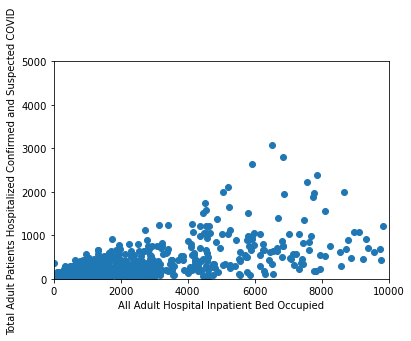

In [274]:
plt.scatter(hospitalized.all_adult_hospital_inpatient_bed_occupied_7_day_sum, hospitalized.total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum)
plt.xlim(0, 10000)
plt.ylim(0, 5000)
plt.xlabel('All Adult Hospital Inpatient Bed Occupied')
plt.ylabel('Total Adult Patients Hospitalized Confirmed and Suspected COVID')
plt.show()

In [275]:
X = hospitalized.all_adult_hospital_inpatient_bed_occupied_7_day_sum.values.reshape(-1, 1)

In [276]:
X[:10]

array([[ 2701.],
       [34494.],
       [  582.],
       [14304.],
       [   96.],
       [ 6838.],
       [ 1733.],
       [  441.],
       [  111.],
       [  368.]])

In [277]:
X.shape

(3000, 1)

In [278]:
y = hospitalized.total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum

In [279]:
model = LinearRegression()

In [280]:
model.fit(X, y)

LinearRegression()

In [281]:
y_pred = model.predict(X)
print(y_pred.shape)

(3000,)


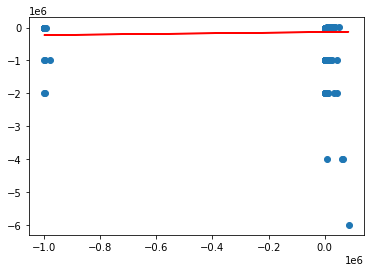

In [282]:
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

In [283]:
print(model.coef_)
print(model.intercept_)

[0.09156551]
-136531.00769670086
